In [1]:
import firebase_admin
from firebase_admin import credentials, firestore
from datetime import datetime, timedelta

cred = credentials.Certificate("C:\\Users\\User\\Desktop\\StockSense\\confidential\\admin.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [11]:
model = load_model("stock_forecast_model.h5")
scaler = MinMaxScaler()

In [6]:
def pre_processing(df):
    data = scaler.fit_transform(X=np.array(df).reshape(-1, 1))[-10:]
    data = np.reshape(data, newshape=(10, 1))
    return data
    

In [7]:
def predict(future_days, last_10):
    new_data = np.expand_dims(last_10, axis=0)   
    for i in range(10, future_days):
        preds = model.predict(new_data[:, i-10:i, :], verbose=0)  # Predict using the last 10 days
        new_data = np.append(new_data, np.expand_dims(preds, 0), axis=1)
    return new_data

In [44]:
def forecast(df, future_days=1, plot=False):
    processed_data = pre_processing(df)
    predictions = predict(10+future_days, processed_data)
    predictions = scaler.inverse_transform(predictions.reshape(10+future_days,1))
    print(f"Actual value: {df[-1]} USD ({df.index[-1]})")
#     return predictions, df[-10:]
    
    last_date = datetime.strptime(str(df.index[-1]), "%Y-%m-%d")    
    for i in range(future_days):
        curr_date = (last_date + timedelta(days=i+1)).strftime("%Y-%m-%d")
    print("Predicted value after {} days: {} USD ({})".format(future_days, round(predictions[10+i][0], 2), curr_date))
        
    if plot == True:

        plt.figure(figsize=(12,4))
        plt.title("Actual and Forecasted Value")
        plt.plot(pd.DataFrame(predictions), label="Prediction")
        plt.xlabel("Date")
        
        plt.plot(pd.DataFrame(df[-10:]), label="Actual")
        plt.ylabel("Price (USD)")
        
        rolling_mean = df.rolling(window=5).mean()
        plt.plot(rolling_mean[-10:], label="Moving Average")
        plt.tight_layout()
        plt.legend()
        plt.show()

In [41]:
df = db.collection("stock_prices_data").where("ticker", "==", "ADBE").get()[0].to_dict()
df = pd.DataFrame(df["prices"]).T["close"].sort_index()[:-1]

Actual value: 514.83 USD (2023-07-14)
Predicted value after 20 days: 525.79 USD (2023-08-03)


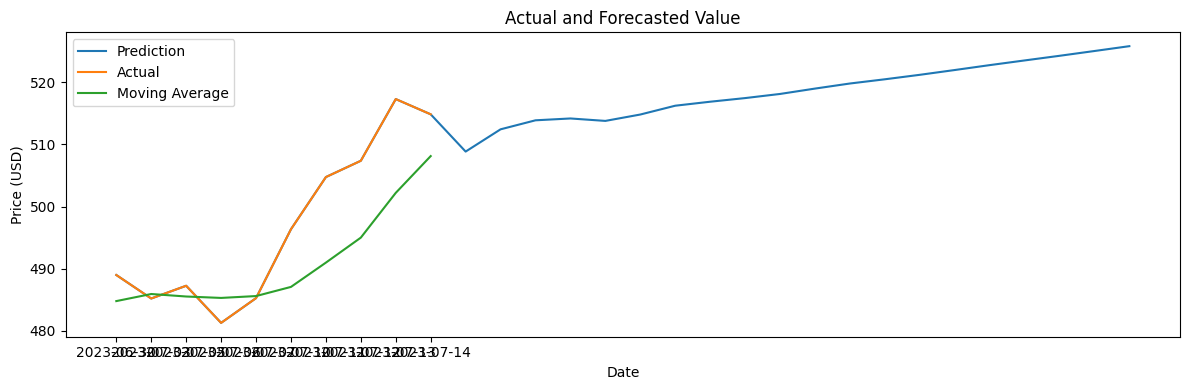

In [43]:
forecast(df, 20, True)

In [91]:
def forecast(df, future_days=1):
    processed_data = pre_processing(df)
    predictions = predict(10+future_days, processed_data)
    predictions = scaler.inverse_transform(predictions.reshape(10+future_days,1))
    
    return round(predictions[10+future_days-1][0], 2)

In [94]:
forecast(df)

508.84